In [81]:
# import libraries
import pandas as pd
import numpy as np
import datetime as dt
import os
import pprint
import requests
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report


# import td client
from td.client import TDClient
#from util import get_data, plot_data, get_orders_data_file

# TD Ameritrade api

In [55]:
def get_data():
    # Create a new session, credentials path is optional.
    TDSession = TDClient(
        client_id='BNGUOCNTSCPWR3EPZSZIPYVNPNLVUIMW',
        redirect_uri='http://localhost:3000',
        #credentials_path='<PATH_TO_CREDENTIALS_FILE>'
    )

    # Login to the session
    TDSession.login()

    # Grab real-time quotes for 'MSFT' (Microsoft)
    msft_quotes = TDSession.get_quotes(instruments=['MSFT'])

    # Grab real-time quotes for 'AMZN' (Amazon) and 'SQ' (Square)
    multiple_quotes = TDSession.get_quotes(instruments=['AMZN','SQ'])

    # pprint.pprint(msft_quotes)

        # Let's define some tickers we want to get the data for five tickers.

    '''
        HD   - Home Depot
        JPM  - JPMorgan Chase & Co.
        GOOG - Google inc.
        ARWR - Arrowhead Pharmaceuticals, Inc.
        COST - Costco Wholesale Corporation
    '''

    # Define the list of tickers
    tickers_list = ['JPM', 'COST', 'GOOG', 'HD', 'ARWR']

    # I need to store multiple result sets.
    full_price_history = []
    
#     minute_data = TDSession.get_price_history(symbol = 'MSFT', period_type = 'day', period = 5, frequency = 1, frequency_type = 'minute')

    for ticker in tickers_list:

        # Grab the daily price history for 1 year
        price_history = TDSession.get_price_history(symbol = ticker, period_type = 'year', 
                                                    period = 2, 
                                                    frequency = 1, 
                                                    frequency_type = 'daily') 
                    

        # grab just the candles, and add them to the list.
        for candle in price_history['candles']:
            candle['symbol'] = price_history['symbol']
            full_price_history.append(candle)
            
    # dump the data to a CSV file, don't have an index column
    price_data = pd.DataFrame(full_price_history).to_csv('price_data.csv', index_label = False)
    


In [60]:
if os.path.exists('price_data.csv'):

    # Load the data
    price_data = pd.read_csv('price_data.csv')

else:

    # Grab the data and store it.
    grab_price_data()

    # Load the data
    price_data = pd.read_csv('price_data.csv')

# Display the head before moving on.
price_data.head()

,open,high,low,close,volume,datetime,symbol
0,108.15,108.34,106.1132,106.36,16199139,1540184400000,JPM
1,104.20,106.16,103.7000,105.25,21407548,1540270800000,JPM
2,104.76,105.03,102.9068,103.29,23168916,1540357200000,JPM
3,104.18,105.90,103.7200,104.86,17464708,1540443600000,JPM
4,104.00,104.56,102.7300,103.42,19174916,1540530000000,JPM


In [65]:
# re-organize the data
price_data = price_data[['symbol','datetime','close','high','low','open','volume']]
price_data.head()

# sort the values by symbol and then date
price_data.sort_values(by = ['symbol','datetime'], inplace = True)

# calculate change in price from day to day
price_data['change_in_price'] = price_data['close'].diff()


# identify rows where the symbol changes
mask = price_data['symbol'] != price_data['symbol'].shift(1)

# For those rows, let's make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value, should only be 5
price_data[price_data.isna().any(axis = 1)]



,symbol,datetime,close,high,low,open,volume,change_in_price
2012,ARWR,1540184400000,12.98,13.1599,12.2500,13.08,1438047,NaN
503,COST,1540184400000,229.06,230.2500,227.2700,229.88,2007324,NaN
1006,GOOG,1540184400000,1101.16,1112.2300,1091.0000,1103.06,1514220,NaN
1509,HD,1540184400000,178.75,181.4000,177.5600,180.82,4866716,NaN
0,JPM,1540184400000,106.36,108.3400,106.1132,108.15,16199139,NaN


# Indicators
Use of momentum indicators to understand direction of stock price. 



Indicator Calculation: Relative Strength Index (RSI)
Definition From Paper:

RSI is a popular momentum indicator that determines whether the stock is overbought or oversold. A stock is said to be overbought when the demand unjustifiably pushes the price upwards. This condition is generally interpreted as a sign that the stock is overvalued, and the price is likely to go down. A stock is said to be oversold when the price goes down sharply to a level below its true value. This is a result caused due to panic selling. RSI ranges from 0 to 100, and generally, when RSI is above 70, it may indicate that the stock is overbought and when RSI is below 30, it may indicate the stock is oversold.

Formula:

$$\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}$$

In [66]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI
2012,ARWR,1540184400000,12.98,13.1599,12.2500,13.08,1438047,NaN,NaN,NaN,NaN
2013,ARWR,1540270800000,12.96,13.2900,12.2900,12.55,1447783,-0.02,0.02,0.00,0.000000
2014,ARWR,1540357200000,11.98,12.9972,11.9800,12.91,2195747,-0.98,0.98,0.00,0.000000
2015,ARWR,1540443600000,12.57,12.8400,12.0000,12.01,1806005,0.59,0.00,0.59,40.567796
2016,ARWR,1540530000000,12.66,12.8900,12.0400,12.33,1319565,0.09,0.00,0.09,44.528648
2017,ARWR,1540789200000,12.25,12.9900,11.8893,12.81,2400423,-0.41,0.41,0.00,32.976543
2018,ARWR,1540875600000,12.46,12.5678,12.0500,12.10,1459896,0.21,0.00,0.21,41.886614
2019,ARWR,1540962000000,12.72,13.1100,12.5100,12.73,1613776,0.26,0.00,0.26,51.161679
2020,ARWR,1541048400000,14.22,14.2300,12.7200,12.76,2676860,1.50,0.00,1.50,76.320188
2021,ARWR,1541134800000,14.49,14.6600,14.0200,14.36,1460780,0.27,0.00,0.27,78.608836


# Indicator Calculation: Stochastic Oscillator
Definition From Paper:

Stochastic Oscillator follows the speed or the momentum of the price. As a rule, momentum changes before the price changes. It measures the level of the closing price relative to the low-high range over a period of time.

In [ ]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
price_data.head(30)

# Indicator Calculation: Williams %R
Definition From Paper:

Williams %R ranges from -100 to 0. When its value is above -20, it indicates a sell signal and when its value is below -80, it indicates a buy signal.

In [67]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,r_percent
2012,ARWR,1540184400000,12.98,13.1599,12.2500,13.08,1438047,NaN,NaN,NaN,NaN,NaN
2013,ARWR,1540270800000,12.96,13.2900,12.2900,12.55,1447783,-0.02,0.02,0.00,0.000000,NaN
2014,ARWR,1540357200000,11.98,12.9972,11.9800,12.91,2195747,-0.98,0.98,0.00,0.000000,NaN
2015,ARWR,1540443600000,12.57,12.8400,12.0000,12.01,1806005,0.59,0.00,0.59,40.567796,NaN
2016,ARWR,1540530000000,12.66,12.8900,12.0400,12.33,1319565,0.09,0.00,0.09,44.528648,NaN
2017,ARWR,1540789200000,12.25,12.9900,11.8893,12.81,2400423,-0.41,0.41,0.00,32.976543,NaN
2018,ARWR,1540875600000,12.46,12.5678,12.0500,12.10,1459896,0.21,0.00,0.21,41.886614,NaN
2019,ARWR,1540962000000,12.72,13.1100,12.5100,12.73,1613776,0.26,0.00,0.26,51.161679,NaN
2020,ARWR,1541048400000,14.22,14.2300,12.7200,12.76,2676860,1.50,0.00,1.50,76.320188,NaN
2021,ARWR,1541134800000,14.49,14.6600,14.0200,14.36,1460780,0.27,0.00,0.27,78.608836,NaN


# Indicator Calculation: Moving Average Convergence Divergnece (MACD)
Definition From Paper:

EMA stands for Exponential Moving Average. When the MACD goes below the SingalLine, it indicates a sell signal. When it goes above the SignalLine, it indicates a buy signal.

In [68]:
# Calculate the MACD
ema_26 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Print the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,r_percent,MACD,MACD_EMA
2012,ARWR,1540184400000,12.98,13.1599,12.2500,13.08,1438047,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2013,ARWR,1540270800000,12.96,13.2900,12.2900,12.55,1447783,-0.02,0.02,0.00,0.000000,NaN,-0.000449,-0.000249
2014,ARWR,1540357200000,11.98,12.9972,11.9800,12.91,2195747,-0.98,0.98,0.00,0.000000,NaN,-0.030961,-0.012836
2015,ARWR,1540443600000,12.57,12.8400,12.0000,12.01,1806005,0.59,0.00,0.59,40.567796,NaN,-0.022779,-0.016204
2016,ARWR,1540530000000,12.66,12.8900,12.0400,12.33,1319565,0.09,0.00,0.09,44.528648,NaN,-0.014272,-0.015629
2017,ARWR,1540789200000,12.25,12.9900,11.8893,12.81,2400423,-0.41,0.41,0.00,32.976543,NaN,-0.026421,-0.018555
2018,ARWR,1540875600000,12.46,12.5678,12.0500,12.10,1459896,0.21,0.00,0.21,41.886614,NaN,-0.024244,-0.019994
2019,ARWR,1540962000000,12.72,13.1100,12.5100,12.73,1613776,0.26,0.00,0.26,51.161679,NaN,-0.010029,-0.017600
2020,ARWR,1541048400000,14.22,14.2300,12.7200,12.76,2676860,1.50,0.00,1.50,76.320188,NaN,0.074387,0.003650
2021,ARWR,1541134800000,14.49,14.6600,14.0200,14.36,1460780,0.27,0.00,0.27,78.608836,NaN,0.147095,0.035790


In [75]:
# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('symbol')['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

close_groups

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# print the head
price_data.head(50)

#price_data

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,r_percent,MACD,MACD_EMA,Prediction
2012,ARWR,1540184400000,12.98,13.1599,12.2500,13.08,1438047,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2013,ARWR,1540270800000,12.96,13.2900,12.2900,12.55,1447783,-0.02,0.02,0.00,0.000000,NaN,-0.000449,-0.000249,-1.0
2014,ARWR,1540357200000,11.98,12.9972,11.9800,12.91,2195747,-0.98,0.98,0.00,0.000000,NaN,-0.030961,-0.012836,-1.0
2015,ARWR,1540443600000,12.57,12.8400,12.0000,12.01,1806005,0.59,0.00,0.59,40.567796,NaN,-0.022779,-0.016204,1.0
2016,ARWR,1540530000000,12.66,12.8900,12.0400,12.33,1319565,0.09,0.00,0.09,44.528648,NaN,-0.014272,-0.015629,1.0
2017,ARWR,1540789200000,12.25,12.9900,11.8893,12.81,2400423,-0.41,0.41,0.00,32.976543,NaN,-0.026421,-0.018555,-1.0
2018,ARWR,1540875600000,12.46,12.5678,12.0500,12.10,1459896,0.21,0.00,0.21,41.886614,NaN,-0.024244,-0.019994,1.0
2019,ARWR,1540962000000,12.72,13.1100,12.5100,12.73,1613776,0.26,0.00,0.26,51.161679,NaN,-0.010029,-0.017600,1.0
2020,ARWR,1541048400000,14.22,14.2300,12.7200,12.76,2676860,1.50,0.00,1.50,76.320188,NaN,0.074387,0.003650,1.0
2021,ARWR,1541134800000,14.49,14.6600,14.0200,14.36,1460780,0.27,0.00,0.27,78.608836,NaN,0.147095,0.035790,1.0


# Removing nan values
he random forest can't accept Nan values, so we will need to remove them before feeding the data in. The code below prints the number of rows before dropping the NaN values, use the dropna method to remove any rows NaN values and then displays the number of rows after dropping the NaN values.

In [76]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
#price_data.head()


Before NaN Drop we have 2515 rows and 15 columns
After NaN Drop we have 2449 rows and 15 columns


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,r_percent,MACD,MACD_EMA,Prediction
2025,ARWR,1541656800000,15.35,16.0900,14.94,16.09,1806345,-0.66,0.66,0.0,71.590169,-17.616112,0.386025,0.207569,-1.0
2026,ARWR,1541743200000,14.49,15.2892,13.75,15.22,2037512,-0.86,0.86,0.0,55.891012,-38.088890,0.356158,0.238371,-1.0
2027,ARWR,1542002400000,12.83,14.4900,12.81,14.49,1769391,-1.66,1.66,0.0,37.550932,-77.606113,0.228340,0.236306,-1.0
2028,ARWR,1542088800000,12.47,13.2836,12.35,12.94,1576228,-0.36,0.36,0.0,34.701551,-86.176114,0.105748,0.209593,-1.0
2029,ARWR,1542175200000,12.06,12.8300,11.84,12.62,1653694,-0.41,0.41,0.0,31.555050,-94.823529,-0.015285,0.163792,-1.0


# Build Random Forest classifier 
TODO: Build line regression model aswell and compare the two outputs
Make persistent model for deployment for deployment

In [83]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','r_percent','MACD']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)


# Model Evaluation: Accuracy

We've built our model, so let's see how accurate it is. SciKit learn, again, makes the process of evaluating our model very easy by providing a bunch of built-in metrics that we can call.

One of those metrics is the accuracy_score.


In [84]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  65.90538336052202


In [85]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.626923,0.592727,0.609346,275.000000
Up Day,0.682720,0.713018,0.697540,338.000000
accuracy,0.659054,0.659054,0.659054,0.659054
macro avg,0.654821,0.652873,0.653443,613.000000
weighted avg,0.657689,0.659054,0.657975,613.000000


# Model Evaluation: Confusion Matrix


Accuracy: 0.6590538336052202
Percision: 0.6827195467422096
Recall: 0.7130177514792899
Specificity: 0.5927272727272728


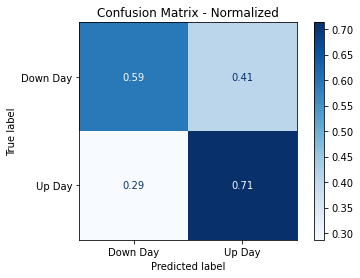

In [86]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

# Model Evaluation: Feature Importance
With any model, you want to have an idea of what features are helping explain most of the model, as this can give you insight as to why you're getting the results you are. With Random Forest, we can identify some of our most important features or, in other words, the features that help explain most of the model. In some cases, some of our features might not be very important, or in other words, when compared to additional features, don't explain much of the model.


In [87]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

r_percent    0.391169
RSI          0.331254
MACD         0.277577
dtype: float64

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

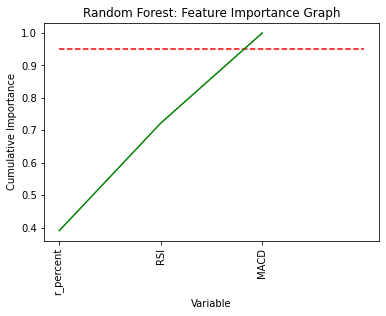

In [88]:
# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

# Model Evaluation: ROC Curve 
The Receiver Operating Characteristic is a graphical method to evaluate the performance of a binary classifier. A curve is drawn by plotting True Positive Rate (sensitivity) against False Positive Rate (1 - specificity) at various threshold values. ROC curve shows the trade-off between sensitivity and specificity. When the curve comes closer to the left-hand border and the top border of the ROC space, it indicates that the test is accurate. The closer the curve is to the top and left-hand border, the more accurate the test is. If the curve is close to the 45 degrees diagonal of the ROC space, it means that the test is not accurate. ROC curves can be used to select the optimal model and discard the suboptimal ones.

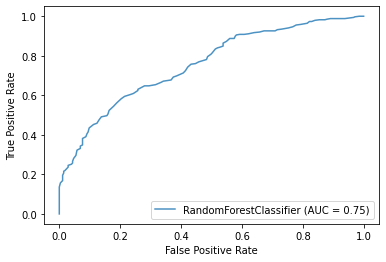

In [89]:
# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()

# Model Improvement
We have to try different values to find what the optimal values should be for each of the parameters. Fortunately, for us, this can be done using the RandomizedSearchCV method provided by sklearn.

The idea behind this approach is to provide a wide range of possible values for each hyperparameter and then using cross-validation, to try different combinations of these parameters. With the highest result of these combinations being the one, we should use for our data set.

To use this method, we need to first import the RandomizedSearchCV object from the sklearn.model_selection module. From there, we need to define a range of values for each of the hyperparameters we wish to test. To do this appropriately, we need to make sure we understand what each argument means in the model, so let's walk through them:

n_estimators - The number of trees in the forest.
max_features - The number of features to consider when looking for the best split.
max_depth - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split - The minimum number of samples required to split an internal node.
min_samples_leaf - The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
bootstrap - Whether bootstrap samples are used when building trees. If False, the whole dataset is used to construct each tree.

In [90]:
# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


# Model Improvement: Running Randomized Search
Now that we've created a range of values for some of our hyperparameters, we can put them to the test. The first thing we need to do is create a new instance of our RandomForestClassifier model and pass it through to our RandomizedSearchCV object. When we use the RandomizedSearchCV, we need to specify a few additional arguments.

The estimator is the model we wish to use; in this case, it's just our RandomForestClassifier. The param_distribution will get our random_grid dictionary. n_iter is an important argument because it will specify the number of iterations we will do, so the higher it is, the more iterations we will do. cv, defines the cross-validation splitting strategy we will use, random_state is used for random uniform sampling. verbose controls the verbosity: the higher, the more messages. n_jobs number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

In [91]:
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', None,
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
          

In [92]:
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)


'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)

Correct Prediction (%):  69.00489396411092


,precision,recall,f1-score,support
Down Day,0.626923,0.592727,0.609346,275.000000
Up Day,0.682720,0.713018,0.697540,338.000000
accuracy,0.659054,0.659054,0.659054,0.659054
macro avg,0.654821,0.652873,0.653443,613.000000
weighted avg,0.657689,0.659054,0.657975,613.000000


r_percent    0.391169
RSI          0.331254
MACD         0.277577
dtype: float64

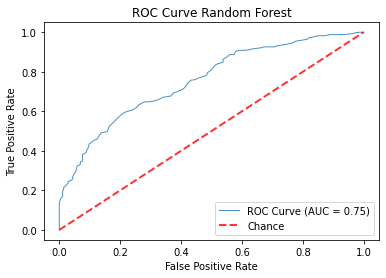

In [93]:
'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()

In [94]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=60, max_features='log2',
                       min_samples_leaf=7, min_samples_split=5,
                       n_estimators=800)

In [79]:
if __name__ == "__main__": 
    get_data()
    

None
